
### **H1N1 예방 접종 예측**
**Pipeline 형성해 RandomForestClassifier 모델링, ROC 함수 구현**

설문 조사의 정보를 사용하여 사람들이 H1N1 백신을 맞았는지 예측할 것입니다.


전염병 퇴치에 사용되는 중요한 공중 보건 조치 인 백신 접종을 살펴볼 것입니다. 백신은 개인에게 예방 접종을 제공하며, 잘 예방 된 지역 사회는 "군집 면역"을 통해 질병의 확산을 더욱 줄일 수 있습니다 .

이 분석의 목표는 **사람들이 자신의 배경, 의견 및 건강 행동에 대해 공유 한 정보를 사용하여 H1N1 백신을 맞았는지 예측**하는 것 입니다.

데이터는 미국 국립 보건 통계 센터에서 제공합니다.

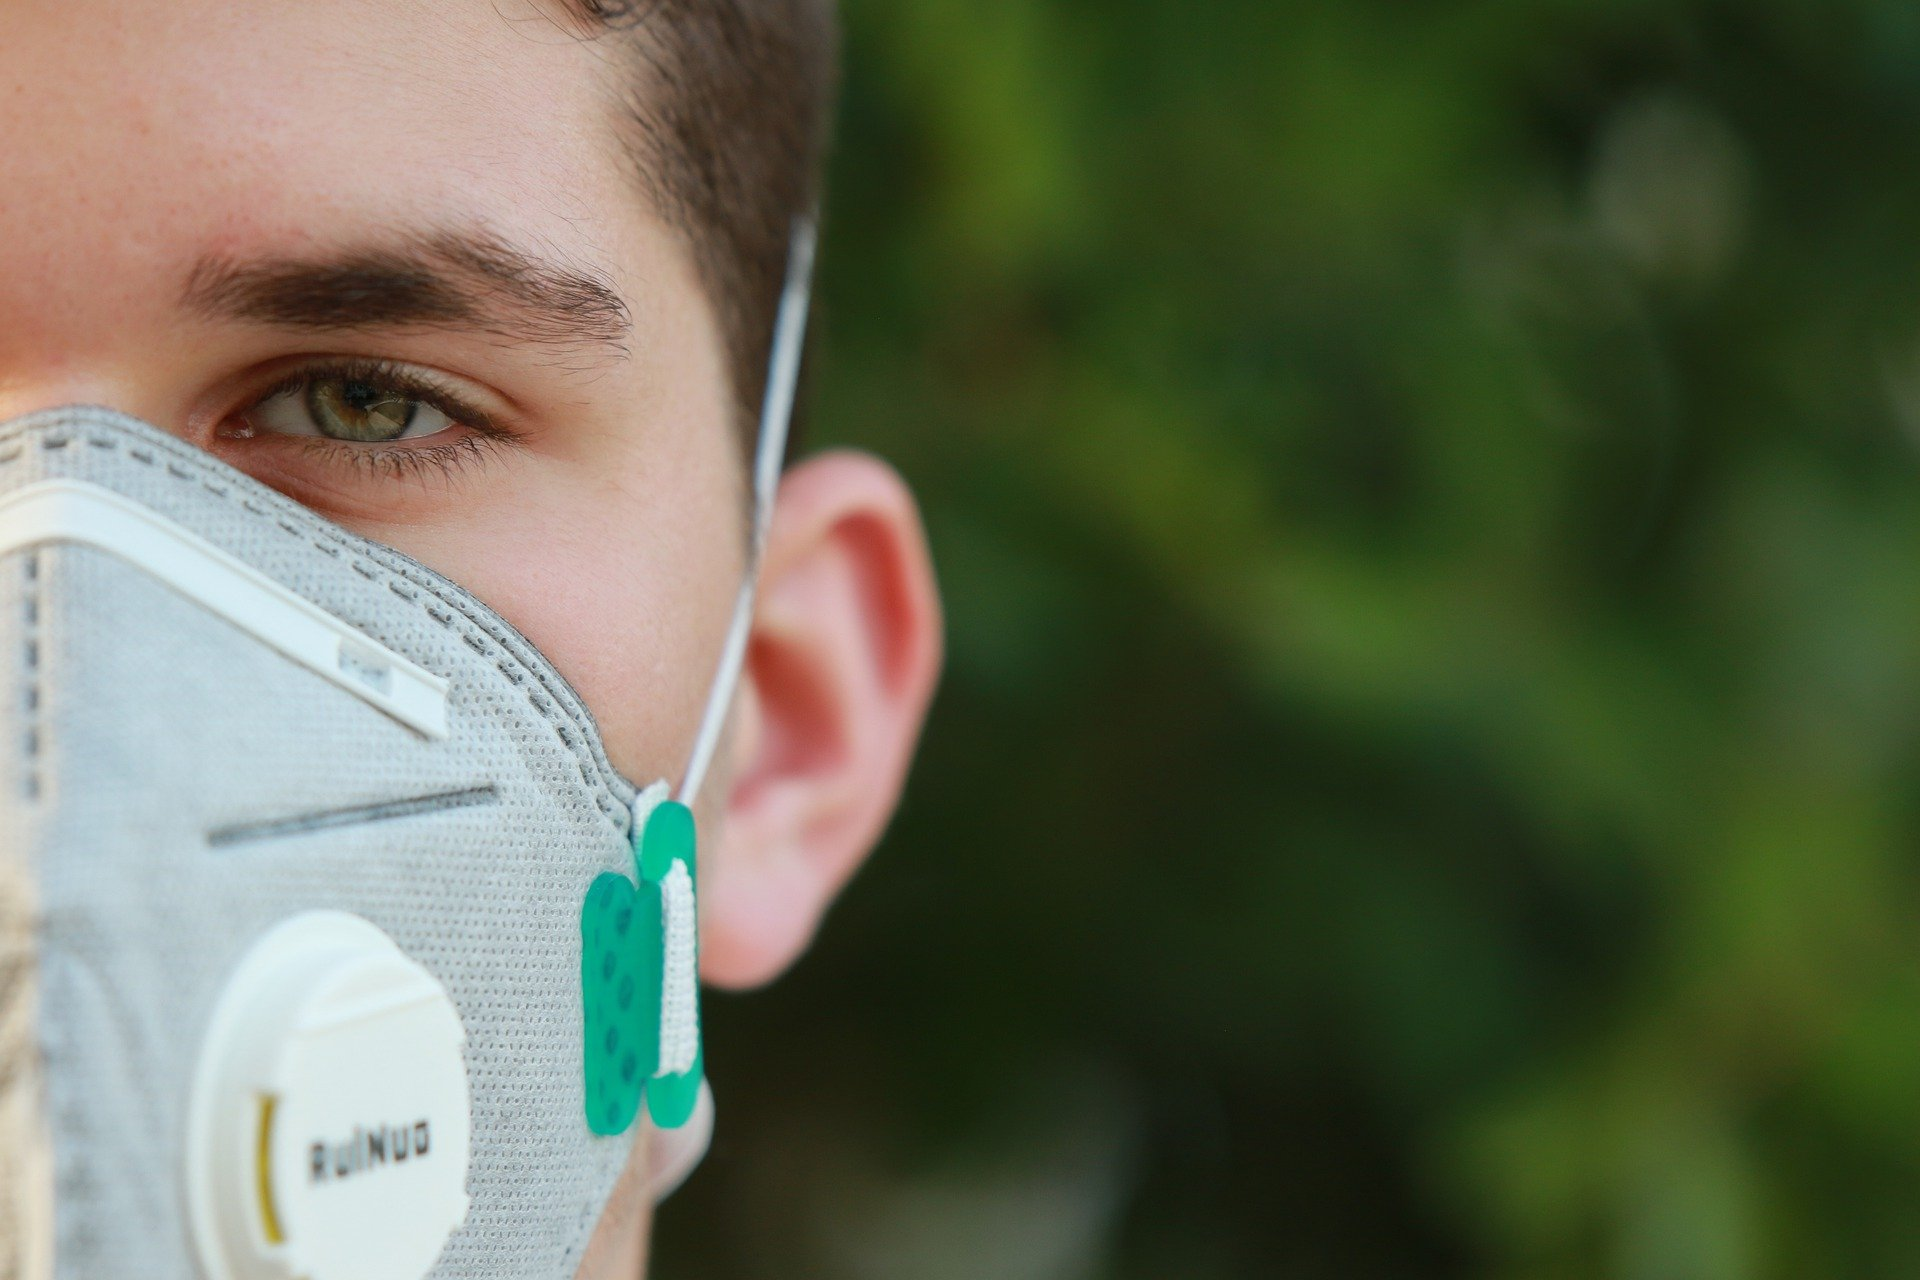

In [ ]:
# 파일을 통해 업로드
from google.colab import files
uploaded = files.upload()

Saving submission.csv to submission.csv
Saving test.csv to test.csv
Saving train.csv to train.csv
Saving train_labels.csv to train_labels.csv


In [ ]:
# category_encoders 설치
!pip install category_encoders

# 필요한 라이브러리 import
import io
import pandas as pd
from sklearn.model_selection import train_test_split
from pandas_profiling import ProfileReport
from sklearn.impute import SimpleImputer
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import make_pipeline
from category_encoders import OneHotEncoder, OrdinalEncoder
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, plot_confusion_matrix, classification_report

     |████████████████████████████████| 81kB 4.8MB/s 


/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [ ]:
submission = pd.read_csv(io.BytesIO(uploaded['submission.csv']))
test = pd.read_csv(io.BytesIO(uploaded['test.csv']))
train = pd.read_csv(io.BytesIO(uploaded['train.csv']))
train_labels = pd.read_csv(io.BytesIO(uploaded['train_labels.csv']))

In [ ]:
# 데이터셋을 분석하기 용이하도록 변경합니다.

target = 'vacc_h1n1_f'
test = pd.read_csv(io.BytesIO(uploaded['test.csv']))
train = pd.merge(pd.read_csv(io.BytesIO(uploaded['train.csv'])), pd.read_csv(io.BytesIO(uploaded['train_labels.csv'])),left_index=True, right_index=True).drop(['vacc_seas_f'],axis=1)

In [ ]:
# Train 데이터 균형을 확인합니다.

train[target].value_counts() #불균형

0    32077
1    10077
Name: vacc_h1n1_f, dtype: int64

In [ ]:
# 데이터 전처리 전, 정보를 확인합니다.
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 42154 entries, 0 to 42153
Data columns (total 39 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   h1n1_concern                 33734 non-null  float64
 1   h1n1_knowledge               33734 non-null  float64
 2   behavioral_antiviral_meds    33635 non-null  float64
 3   behavioral_avoidance         33482 non-null  float64
 4   behavioral_face_mask         33710 non-null  float64
 5   behavioral_wash_hands        33683 non-null  float64
 6   behavioral_large_gatherings  33640 non-null  float64
 7   behavioral_outside_home      33633 non-null  float64
 8   behavioral_touch_face        33571 non-null  float64
 9   doctor_recc_h1n1             40269 non-null  float64
 10  doctor_recc_seasonal         40269 non-null  float64
 11  chronic_med_condition        40837 non-null  float64
 12  child_under_6_months         32705 non-null  float64
 13  health_insurance

In [ ]:
# cardinality 확인
train.describe(exclude='number').T.sort_values(by='unique', ascending=False)

,count,unique,top,freq
state,42154,51,NEW MEXICO,1017
employment_occupation,17165,25,Management Occupations,2188
employment_industry,17165,23,Health Care and Social Assistance Industries,3086
agegrp,42154,7,65+ Years,8517
opinion_h1n1_vacc_effective,33375,6,Somewhat Effective,14729
opinion_h1n1_risk,33329,6,Somewhat Low,12520
opinion_h1n1_sick_from_vacc,33285,6,Not Very Worried,11582
opinion_seas_vacc_effective,33220,6,Somewhat Effective,14543
opinion_seas_risk,33153,6,Somewhat Low,11397
opinion_seas_sick_from_vacc,33089,6,Not At All Worried,14749


In [ ]:
# 높은 cardinality 삭제하는 함수 생성

def carninality(df,num):
  labels = df.nunique()
  selected_features = labels[labels <= num].index.tolist()
  df = df[selected_features]
  return df

# cardinality 제거 함수 적용
train = carninality(train,30)
test = carninality(test,30)

In [ ]:
# columns 차이 확인
test.columns.difference(train.columns)

Index([], dtype='object')

In [ ]:
# Train 데이터(train)와 Validation 데이터(val) - 각 Feature와 Target 나누기

X_train, X_val, y_train, y_val = train_test_split(train.drop([target],axis=1), train[target], test_size=0.2)
for i in X_train, X_val, y_train, y_val : i.reset_index(inplace=True, drop=True)

In [ ]:
# Pipeline 생성

pipe_onehot = make_pipeline(
    OneHotEncoder(),
    SimpleImputer(),
    RandomForestClassifier(oob_score=True)) # Out of bag : 추출되지 않은 데이터를 활용해 score 검증

pipe_ordinal = make_pipeline(
    OrdinalEncoder(),
    SimpleImputer(),
    RandomForestClassifier(oob_score=True)) # Out of bag : 추출되지 않은 데이터를 활용해 score 검증

In [ ]:
# Ordinal 인코딩

pipe_ordinal.fit(X_train, y_train)
pred = pipe_ordinal.predict(X_val)

print('Validation Accuracy Score: ', accuracy_score(y_val, pred).round(5) )
print('Validation Score: ', pipe_ordinal.score(X_val, y_val).round(5) )
print('Out Of Bag Score: ', pipe_ordinal.named_steps['randomforestclassifier'].oob_score_.round(5) )

Validation Accuracy Score:  0.82149
Validation Score:  0.82149
Out Of Bag Score:  0.82143


In [ ]:
from sklearn.metrics import roc_curve

# ROC 함수 만들기
def make_roc_df(y_val,pred):
  fpr, tpr, thresholds = roc_curve(y_val, pred)
  roc = pd.DataFrame({
      'FPR(Fall-out)': fpr, 
      'TPRate(Recall)': tpr, 
      'Threshold': thresholds
  })
  plt.scatter(fpr, tpr)

In [ ]:
# 네 개의 분류 모델 생성 
# 이때, GridSearchCV HyperParameter 지정 방법을 이용하지 않고(다른 파일에서 할 예정) for문으로 모델 생성

a=[]

for i in [10,100]:
  for n in [5,10]:
    pipe_ordinal = make_pipeline(
      OrdinalEncoder(),
      SimpleImputer(),
      RandomForestClassifier(oob_score=True, n_estimators=i, max_depth=n))
    pipe_ordinal.fit(X_train, y_train)
    pred = pipe_ordinal.predict(X_val)
    a.append(pred)
    make_roc_df(y_val,pred)

/usr/local/lib/python3.6/dist-packages/sklearn/ensemble/_forest.py:523: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/usr/local/lib/python3.6/dist-packages/sklearn/ensemble/_forest.py:528: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])
/usr/local/lib/python3.6/dist-packages/sklearn/ensemble/_forest.py:523: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/usr/local/lib/python3.6/dist-packages/sklearn/ensemble/_forest.py:528: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


In [ ]:
# 4개의 분류모델 정확도 비교
print(accuracy_score(a[0],y_val))
print(accuracy_score(a[1],y_val))
print(accuracy_score(a[2],y_val))
print(accuracy_score(a[3],y_val))

0.8049339764370997
0.8224084763184945
0.8122874990116233
0.8271526844310904


In [ ]:
# 정확도가 a[2]일때 제일 높으므로, a[2]인 경우를 활용해 X_test 진행

a=[]
for i in [10,100]:
  for n in [5,10]:
    pipe_ordinal = make_pipeline(
      OrdinalEncoder(),
      SimpleImputer(),
      RandomForestClassifier(oob_score=True, n_estimators=i, max_depth=n))
    pipe_ordinal.fit(X_train, y_train)
    pred = pipe_ordinal.predict(test)
    a.append(pred)

/usr/local/lib/python3.6/dist-packages/sklearn/ensemble/_forest.py:523: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/usr/local/lib/python3.6/dist-packages/sklearn/ensemble/_forest.py:528: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])
/usr/local/lib/python3.6/dist-packages/sklearn/ensemble/_forest.py:523: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/usr/local/lib/python3.6/dist-packages/sklearn/ensemble/_forest.py:528: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


In [ ]:
#예측값과 submission 을 병합

submission_file = pd.merge(submission,pd.DataFrame(a[2]),right_index=True,left_index=True)

In [ ]:
# 위 파일 다운로드

submission_file.to_csv('submission_file.csv')
files.download('submission_file.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>